The fitting tools have been updated in `fitting.py` to unify the way that the `MultiBeam` or drizzled stacks are fit.

**This requires the development branch "clean_fit_outputs"** (https://github.com/gbrammer/grizli/tree/clean_fit_outputs).  To check out that branch, use the following in the grizli repo directory

    git checkout -b clean_fit_outputs origin/clean_fit_outputs

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli

No TEAL-based tasks available for this package!
The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


==========
Pre-processing of the FLT exposures done in WFC3IR_Reduction.ipynb of the ERS grism data

In [3]:
os.chdir('Prep') # Maybe necessary depending on where the notebook is run

all_grism_files = ['ib6o21qmq_flt.fits', 'ib6o21qoq_flt.fits', 'ib6o21r6q_flt.fits', 
                   'ib6o21r8q_flt.fits', 'ib6o23rsq_flt.fits', 'ib6o23ruq_flt.fits', 
                   'ib6o23ryq_flt.fits','ib6o23s0q_flt.fits']

grp = grizli.multifit.GroupFLT(grism_files=all_grism_files, direct_files=[], 
              ref_file='../Catalog/ERS_goodss_3dhst.v4.0.F160W_orig_sci.fits',
              seg_file='../Catalog/ERS_GOODS-S_IR.seg.fits',
              catalog='../Catalog/ERS_GOODS-S_IR.cat',
              cpu_count=8)

Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 5.41 sec.


Now provide two ways of saving the extracted 2D spectra of a given object:  "beams" cutouts from the FLT files and drizzled combinations of them, combined for the available grisms separately and for combinations of the available PAs.

In [4]:
# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

# Show the template names / dictionary keys
fmt = '{0:<36s} {1:<36s}'
print(fmt.format('templ0', 'templ1'))
print(fmt.format('------', '------'))

for i in range(len(templ1)):
    if i > len(templ0)-1:
        print(fmt.format('', list(templ1.keys())[i]))
    else:
        print(fmt.format(list(templ0.keys())[i], list(templ1.keys())[i]))

# Parameters for drizzled line maps
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

templ0                               templ1                              
------                               ------                              
fsps/fsps_QSF_12_v3_nolines_001.dat  fsps/fsps_QSF_12_v3_nolines_001.dat 
fsps/fsps_QSF_12_v3_nolines_002.dat  fsps/fsps_QSF_12_v3_nolines_002.dat 
fsps/fsps_QSF_12_v3_nolines_003.dat  fsps/fsps_QSF_12_v3_nolines_003.dat 
fsps/fsps_QSF_12_v3_nolines_004.dat  fsps/fsps_QSF_12_v3_nolines_004.dat 
fsps/fsps_QSF_12_v3_nolines_005.dat  fsps/fsps_QSF_12_v3_nolines_005.dat 
fsps/fsps_QSF_12_v3_nolines_006.dat  fsps/fsps_QSF_12_v3_nolines_006.dat 
fsps/fsps_QSF_12_v3_nolines_007.dat  fsps/fsps_QSF_12_v3_nolines_007.dat 
fsps/fsps_QSF_12_v3_nolines_008.dat  fsps/fsps_QSF_12_v3_nolines_008.dat 
fsps/fsps_QSF_12_v3_nolines_009.dat  fsps/fsps_QSF_12_v3_nolines_009.dat 
fsps/fsps_QSF_12_v3_nolines_010.dat  fsps/fsps_QSF_12_v3_nolines_010.dat 
fsps/fsps_QSF_12_v3_nolines_011.dat  fsps/fsps_QSF_12_v3_nolines_011.dat 
fsps/fsps_QSF_12_v3_nolines_012.dat  f

ers-grism_40776.beams.fits


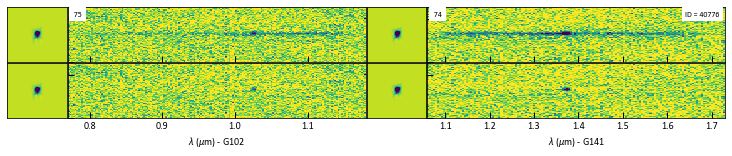

In [5]:
# grp `GroupFLT` object created as defined in WFC3IR_Reduction from the WFC3 ERS grism data
target = 'ers-grism'

# Line-emitter
id=40776

# Weak continuum features
#id=41147

# Strong continuum 
#id=43114

# Pull out the 2D cutouts
beams = grp.get_beams(id, size=80)
mb = grizli.multifit.MultiBeam(beams, fcontam=0.5, group_name=target, psf=False)

# Save a FITS file with the 2D cutouts (beams) from the individual exposures
mb.write_master_fits()

# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(wave, order=7)
pfit = mb.template_at_z(z=0, templates=poly_templates, fit_background=True, 
                        fitter='lstsq', get_uncertainties=2)

# Drizzle grisms / PAs
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
                                     size=32, zfit=pfit)

# Save drizzle figure FITS file
fig.savefig('{0}_{1:05d}.stack.png'.format(target, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(target, id), clobber=True)

Load file ers-grism_40776.stack.fits
Mask 0 additional pixels for ext G102,75.0
Mask 0 additional pixels for ext G141,74.0
1 ib6o21qmq_flt.fits G102
2 ib6o21qoq_flt.fits G102
3 ib6o21r6q_flt.fits G102
4 ib6o21r8q_flt.fits G102
5 ib6o23rsq_flt.fits G141
6 ib6o23ruq_flt.fits G141
7 ib6o23ryq_flt.fits G141
8 ib6o23s0q_flt.fits G141
Drizzle line -> OIII (15.00 0.99)
Drizzle line -> Hb   (3.47 0.83)
Drizzle line -> OII  (9.40 1.11)


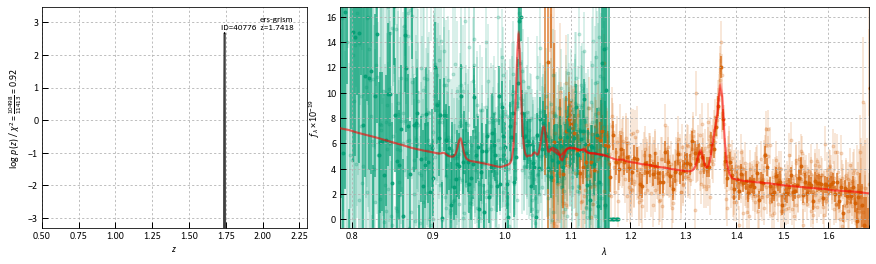

In [6]:
from imp import reload

# High-level wrapper script for doing everything (redshift fits, line fluxes, drizzled line 
# maps).  More explanation of the details of individual steps TBD.
#
# Needs to be able to find {target}_{id:05d}.beams.fits and {target}_{id:05d}.stack.fits 
# generated above
out = grizli.fitting.run_all(id, t0=templ0, t1=templ1, fwhm=1200, 
                             zr=[0.5, 2.3], dz=[0.004, 0.0005], 
                             fitter='nnls', group_name=target, prior=None, fcontam=0.,
                             pline=pline, mask_sn_limit=7, fit_beams=True, fit_stacks=False,  
                             root=target+'_', fit_trace_shift=False, verbose=False, 
                             phot=None, scale_photometry=False, show_beams=True)

In [7]:
# Products
mb, st, fit, tfit, line_hdu = out

# Objects that are used for the fitting.  They are 
# both subclasses of grizli.fitting.GroupFitter, 
# which provides the fitting methods.
print('mb: ', mb.__class__) # From "beams.fits"
print('st: ', st.__class__) # Drizzled spectra from "stack.fits"

mb:  <class 'grizli.multifit.MultiBeam'>
st:  <class 'grizli.stack.StackFitter'>


Fit table: ['zgrid', 'chi2', 'coeffs', 'covar', 'pdf', 'risk']
N (2, 'Number of spectrum extensions')
polyord (3, 'Order polynomial fit')
chi2poly (2648.7985469874097, 'Chi^2 of polynomial fit')
DoF (2460, 'Degrees of freedom (number of pixels)')
chimin (2374.1052947371736, 'Minimum chi2')
chimax (2743.6146809633428, 'Maximum chi2')
fitter ('nnls', 'Minimization algorithm')
bic_poly (321.5407520237946, 'BIC of polynomial fit')
bic_temp (39.03958314463204, 'BIC of template fit')
NTEMP (16, 'Number of fitting templates')
T001NAME ('fsps/fsps_QSF_12_v3_nolines_001.dat', 'Template name')
T002NAME ('fsps/fsps_QSF_12_v3_nolines_002.dat', 'Template name')
T003NAME ('fsps/fsps_QSF_12_v3_nolines_003.dat', 'Template name')
T004NAME ('fsps/fsps_QSF_12_v3_nolines_004.dat', 'Template name')
T005NAME ('fsps/fsps_QSF_12_v3_nolines_005.dat', 'Template name')
T006NAME ('fsps/fsps_QSF_12_v3_nolines_006.dat', 'Template name')
T007NAME ('fsps/fsps_QSF_12_v3_nolines_007.dat', 'Template name')
T008NAME ('fs

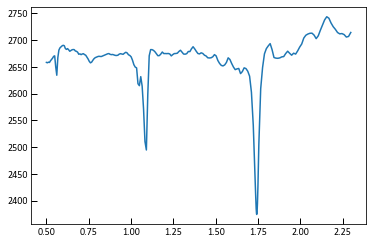

In [8]:
# Properties of the fit on the redshift grid
# stored in an astropy.table.Table
print('Fit table:', fit.colnames)
for k in fit.meta:
    print(k, fit.meta[k])
    
plt.plot(fit['zgrid'], fit['chi2'])

odict_keys(['cont1d', 'line1d', 'cfit', 'coeffs', 'covar', 'z', 'templates'])
z = 1.7417940905525213
Continuum template, cont1d:  <class 'grizli.utils.SpectrumTemplate'>


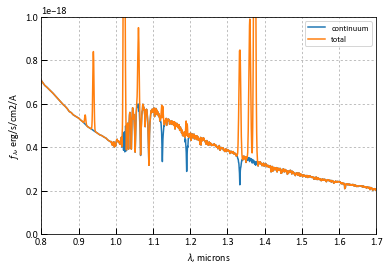

In [9]:
# Results of the fit at the best determined redshift
print(tfit.keys())
print('z = {0}'.format(tfit['z']))

print('Continuum template, cont1d: ', tfit['cont1d'].__class__)
plt.plot(tfit['cont1d'].wave/1.e4, tfit['cont1d'].flux, label='continuum')
plt.plot(tfit['line1d'].wave/1.e4, tfit['line1d'].flux, label='total')
plt.xlim(0.8, 1.7); plt.ylim(0,1.e-18); plt.grid()
plt.xlabel(r'$\lambda$, microns'); plt.ylabel(r'$f_\lambda$, erg/s/cm2/A'); plt.legend()

# cfit, coeffs, covar are coefficients of the template fit
# and their covariance

## Retrieving the fit output
All of the information above is also stored in the `*full.fits` file, so you don't have to 
retrieve the outputs directly from the fitting script.

In [10]:
fit_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(target, id)) 
fit_hdu.info()

Filename: ers-grism_40776.full.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      48   ()              
1    ZFIT_STACK  BinTableHDU     64   231R x 6C    [D, D, 18D, 324D, D, D]   
2    ZFIT_BEAM   BinTableHDU     64   62R x 6C     [D, D, 24D, 576D, D, D]   
3    TEMPL       BinTableHDU    150   5665R x 3C   [D, D, D]   
4    COVAR       ImageHDU       153   (44, 44)     float64   
5    DSCI        ImageHDU        20   (80, 80)     float32   
6    DWHT        ImageHDU        20   (80, 80)     float32   
7    LINE        ImageHDU        24   (80, 80)     float32   
8    CONTINUUM   ImageHDU        24   (80, 80)     float32   
9    CONTAM      ImageHDU        24   (80, 80)     float32   
10   LINEWHT     ImageHDU        24   (80, 80)     float32   
11   LINE        ImageHDU        24   (80, 80)     float32   
12   CONTINUUM   ImageHDU        24   (80, 80)     float32   
13   CONTAM      ImageHDU        24   (80, 80)     float32   
14   LINEWH

In [11]:
# Basic properties of the input data
fit_hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                40776 / Object ID                                      
RA      =    53.06570059828451 / Central R.A.                                   
DEC     =   -27.72041410491778 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                    8 / Number of drizzled beams                       
FILE0001= 'ib6o21qmq_flt.fits' / Parent filename                                
GRIS0001= 'G102    '           / Beam grism element                             
PA0001  =                 74

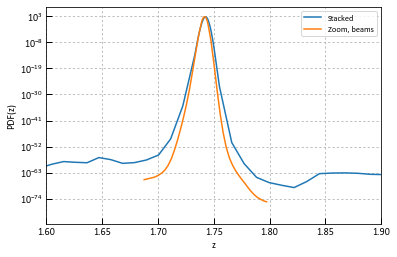

In [12]:
from astropy.table import Table

# same as the fit table above, redshift fit to the stacked spectra
fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 
plt.plot(fit_stack['zgrid'], fit_stack['pdf'], label='Stacked')

# zoom in around the initial best-guess with the individual "beam" spectra
fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   
plt.plot(fit_beam['zgrid'], fit_beam['pdf'], label='Zoom, beams')

plt.xlim(1.6, 1.9); plt.semilogy(); plt.grid()
plt.xlabel('z'); plt.ylabel('PDF(z)'); plt.legend()


In [13]:
# Best-fit templates, like `tfit` above
templ = Table(fit_hdu['TEMPL'].data)
print(templ.colnames)

['wave', 'continuum', 'full']


ers-grism_40776.full.fits has lines [OIII Hb OII]


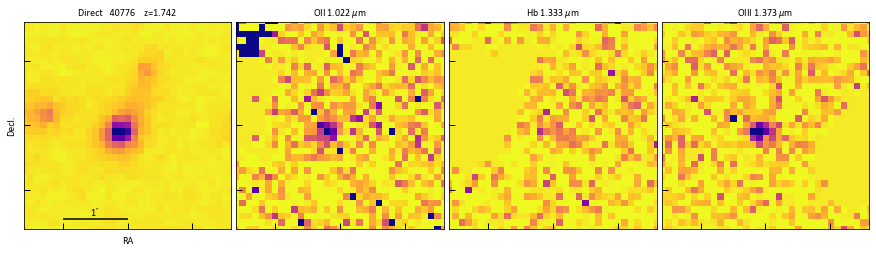

In [14]:
# Extensions 'DSCI', 'LINE', 'LINEWHT'... contain the drizzled line maps
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

# Helper script for plotting them, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(target, id))